In [8]:
import torch
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from collections import Counter


In [9]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")  

tensor([1.], device='mps:0')


In [10]:
ss = SnowballStemmer('spanish')
sw = stopwords.words('spanish')
tokenizer = RegexpTokenizer(r'\w+')

In [11]:
!ls -lh ./workspace/mmia-6021-fall24/guides/data/

total 1800
-rw-r--r--@ 1 aproano  staff    35K Aug 23 22:45 cap1.txt
-rw-r--r--@ 1 aproano  staff    34K Aug 23 13:29 chapter1.txt
-rw-rw-r--@ 1 aproano  staff   826K Dec 11  2018 gabriel_garcia_marquez_cien_annos_soledad.txt


In [12]:
!head -c 1000 './workspace/mmia-6021-fall24/guides/data/gabriel_garcia_marquez_cien_annos_soledad.txt'

Gabriel García Márquez 



Cien años de soledad 



EDITADO POR "EDICIONES LA CUEVA" 



Para J omi García Ascot 
y María Luisa Elio 



Cien años de soledad 



Gabriel García Márquez 



Muchos años después, frente al pelotón de fusilamiento, el coronel Aureliano Buendía había de 
recordar aquella tarde remota en que su padre lo llevó a conocer el hielo. Macondo era entonces 
una aldea de veinte casas de barro y cañabrava construidas a la orilla de un río de aguas diáfanas 
que se precipitaban por un lecho de piedras pulidas, blancas y enormes como huevos 
prehistóricos. El mundo era tan reciente, que muchas cosas carecían de nombre, y para 
mencionarlas había que señalarías con el dedo. Todos los años, por el mes de marzo, una familia 
de gitanos desarrapados plantaba su carpa cerca de la aldea, y con un grande alboroto de pitos y 
timbales daban a conocer los nuevos inventos. Primero llevaron el imán. Un gitano corpulento, de 
barba montaraz y manos de gorri

In [177]:
text = open('./workspace/mmia-6021-fall24/guides/data/gabriel_garcia_marquez_cien_annos_soledad.txt', 'r').read().lower()
# text = open('./workspace/mmia-6021-fall24/guides/data/cap1.txt', 'r').read().lower()

In [199]:
def split_tokens(text):
    tokens = tokenizer.tokenize(text)
    tokens = [w for w in tokens if w not in sw]
    #tokens = [ss.stem(w) for w in tokens if w not in sw]
    return tokens


In [200]:
tokens = split_tokens(text)

In [201]:
tokens[:20]

['gabriel',
 'garcía',
 'márquez',
 'cien',
 'años',
 'soledad',
 'editado',
 'ediciones',
 'cueva',
 'j',
 'omi',
 'garcía',
 'ascot',
 'maría',
 'luisa',
 'elio',
 'cien',
 'años',
 'soledad',
 'gabriel']

In [202]:
counts = Counter(tokens)

In [203]:
counts

Counter({'aureliano': 794,
         'úrsula': 514,
         'arcadio': 480,
         'casa': 463,
         'josé': 424,
         'buendía': 406,
         'años': 357,
         'coronel': 312,
         'amaranta': 310,
         'segundo': 308,
         'dijo': 283,
         'tan': 273,
         'entonces': 272,
         'tiempo': 269,
         'márquez': 241,
         'si': 236,
         'después': 229,
         'vez': 227,
         'sino': 219,
         'fernanda': 218,
         'soledad': 217,
         'sólo': 204,
         'mientras': 192,
         'dos': 191,
         'gabriel': 184,
         'cien': 182,
         'noche': 181,
         'macondo': 180,
         'garcía': 173,
         'nadie': 162,
         'hizo': 160,
         'día': 157,
         'guerra': 152,
         'tarde': 149,
         'mismo': 143,
         'cuarto': 141,
         'mujer': 140,
         'hombre': 139,
         'vio': 139,
         'muerte': 136,
         'nunca': 136,
         'mundo': 132,
         'siem

In [204]:
counts_more_than_1 = {k:v for k,v in counts.items() if v > 1}

In [205]:
vocab = list(counts_more_than_1.keys())
itot = dict(enumerate(vocab))
ttoi = {v:k for k,v in itot.items()}

In [206]:
tokens_more_than_1 = [w for w in tokens if w in vocab]

### Let's prepare the window for word2vec

In [207]:
def window(tokens, win=2):
    output = []
    for i, w in enumerate(tokens):
        target = ttoi[w]
        window = [tokens[i+j] for j in range(-win, win+1,1) 
                  if (i+j >= 0) & (i+j < len(tokens)) & (j != 0)]
       # print(window)
        output += [(target, ttoi[j]) for j in window]
    return output

In [208]:
data_windowed = window(tokens_more_than_1, win=4)

In [209]:
data_windowed

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 8),
 (6, 1),
 (6, 9),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 8),
 (7, 1),
 (7, 9),
 (7, 3),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 7),
 (8, 1),
 (8, 9),
 (8, 3),
 (8, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 3),
 (1, 4),
 (1, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 1),
 (9, 3),
 (9, 4),
 (9, 5),
 (9, 0),
 (3, 7),
 (3, 8),
 (3, 1),
 (3, 9),
 (3, 4),
 (3, 5),
 (3, 0),
 (3, 1),
 (4, 8),
 (4, 1),
 (4, 9),
 (4, 3),
 (4, 5),
 (4, 0),
 (4, 1),
 (4, 2),
 (5, 1),
 (5, 9),
 (5, 3),
 (5, 4),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 4),
 (0, 9),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 1),
 (0, 2),
 (0, 4),
 (0, 10),
 (1, 3),


In [210]:
class text_dataset(Dataset):
    def __init__(self, data_windowed, vocab_size):
        self.data = data_windowed
        self.vocab_size = vocab_size
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x0, y = self.data[idx]
        x =  F.one_hot(torch.tensor(x0), num_classes=self.vocab_size)
        return x, y


In [211]:
dataset = text_dataset(data_windowed, len(vocab))

### Building the network

In [212]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        hidden = self.embed(input.to(torch.int64))
        logits = self.expand(hidden)
        return logits

In [213]:
model = Word2Vec(len(vocab), 100)

In [214]:
model

Word2Vec(
  (embed): Embedding(7406, 100)
  (expand): Linear(in_features=100, out_features=7406, bias=False)
)

In [215]:
LR = 3e-3
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


In [ ]:
from tqdm import tqdm  # For progress bars

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
progress_bar = tqdm(range(EPOCHS * len(dataloader)))
running_loss = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader:
        #center, context = center.to(mps_device), context.to(mps_device)
        context = context.to(torch.float)
        center = center.to(torch.float)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update()
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)




100%|█████████████████████████████████████████████████████████████████████████████| 84450/84450 [10:08<00:00, 138.72it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 58218/77490 [08:13<03:15, 98.46it/s]


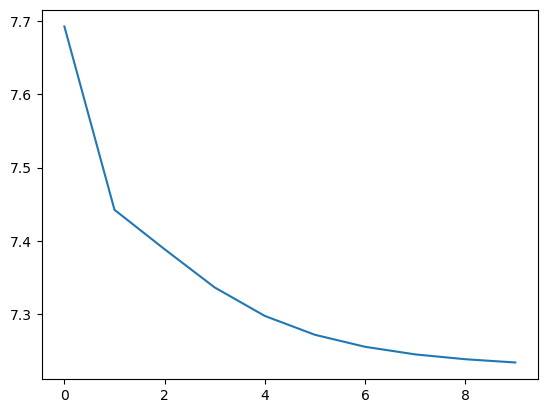

In [194]:
import matplotlib.pyplot as plt
plt.plot(running_loss)

In [195]:
wordvecs = model.expand.weight.cpu().detach().numpy()

In [196]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

# n * (n-1) / 2
def get_k_similar_words(word, dist_matrix, k=10):
    idx = ttoi[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, itot[i], dists[i]) for i in ind]
    return out

In [198]:
dmat = get_distance_matrix(wordvecs, 'cosine')
tokens_test = ['aureliano', 'coronel', 'macondo', 'casa', 'pueblo', 'melquíades', 'arcadio', 'úrsula']
tokens_test = [ss.stem(w) for w in tokens_test if w not in sw]
for word in tokens_test:
    print(word, [t[1] for t in get_k_similar_words(word, dmat, k=10)], "\n")

aurelian ['entonc', 'segund', 'ursul', 'volv', 'cas', 'viv', 'hiz', 'hij', 'buend', 'mientr'] 

coronel ['buend', 'guerr', 'aurelian', 'muert', 'hij', 'marquez', 'entonc', 'segund', 'fusil', 'arcadi'] 

macond ['lleg', 'puebl', 'famili', 'mar', 'part', 'regres', 'ultim', 'viv', 'tiemp', 'conoc'] 

cas ['encontr', 'pas', 'noch', 'ursul', 'volv', 'llev', 'aurelian', 'mientr', 'viv', 'tiemp'] 

puebl ['macond', 'regres', 'mar', 'lleg', 'nuev', 'famili', 'tod', 'cambi', 'viv', 'sid'] 

melquiad ['trat', 'perd', 'parec', 'vid', 'unic', 'pes', 'segund', 'viv', 'tiemp', 'oro'] 

arcadi ['jos', 'buend', 'segund', 'aurelian', 'viv', 'dej', 'dio', 'trat', 'mientr', 'hiz'] 

ursul ['amarant', 'volv', 'cas', 'mientr', 'entonc', 'aurelian', 'fernand', 'pas', 'niñ', 'dej'] 



In [163]:
wordvecs[0]

array([-0.3360056 , -0.24738875, -0.63779116, -0.42893454,  0.56528026,
       -0.11122371, -0.10018123,  0.32480437, -1.0500808 , -0.43980813],
      dtype=float32)

In [161]:
EPOCHS = 50
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader:
        #center, context = center.to(mps_device), context.to(mps_device)
        context = context.to(torch.float)
        center = center.to(torch.float)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update()
    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)


12057it [00:40, 1708.30it/s]                                                                                             

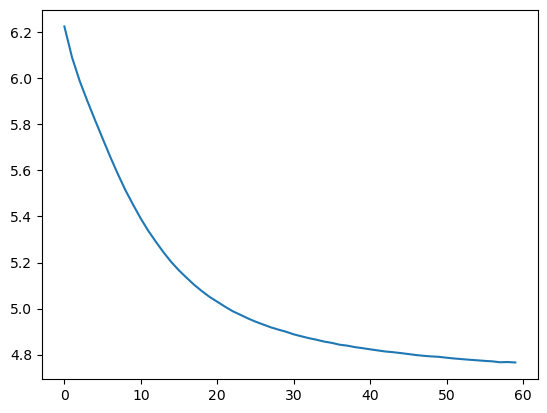

In [164]:
plt.plot(running_loss)

In [165]:
wordvecs_50_epochs = model.expand.weight.cpu().detach().numpy()
dmat_50_epochs = get_distance_matrix(wordvecs_50_epochs, 'cosine')

In [166]:
for word in tokens_test:
    print(word, [t[1] for t in get_k_similar_words(word, dmat_50_epochs)], "\n")

aureliano ['tarde', 'coronel', 'juventud', 'pelotón', 'fusilamiento', 'daba', 'iba', 'pequeño', 'recordar', 'marzo'] 

coronel ['fusilamiento', 'pelotón', 'después', 'frente', 'isla', 'aureliano', 'daba', 'quedaron', 'atravesar', 'recordar'] 

macondo ['aldea', 'entonces', 'todas', 'hombres', 'mientras', 'años', 'lugar', 'partes', 'laboratorio', 'josé'] 

casa ['tan', 'mismo', 'sino', 'úrsula', 'mujer', 'mundo', 'vida', 'vez', 'propia', 'mientras'] 

pueblo ['desmontar', 'empresa', 'puerta', 'posibilidad', 'oyó', 'sabiendo', 'astrolabio', 'trabajo', 'herramientas', 'brújula'] 

melquíades ['aquel', 'aquella', 'josé', 'buendía', 'arcadio', 'gitano', 'hombre', 'mundo', 'niños', 'úrsula'] 

arcadio ['josé', 'buendía', 'aquel', 'niños', 'melquíades', 'siempre', 'hombre', 'entonces', 'tiempo', 'mientras'] 

úrsula ['punto', 'niños', 'aquel', 'tan', 'aquella', 'toda', 'vida', 'mujer', 'melquíades', 'siempre'] 



In [167]:
for word in tokens_test:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

aureliano ['tarde', 'coronel', 'juventud', 'pelotón', 'fusilamiento', 'daba', 'iba', 'pequeño', 'recordar', 'marzo'] 

coronel ['fusilamiento', 'pelotón', 'después', 'frente', 'isla', 'aureliano', 'daba', 'quedaron', 'atravesar', 'recordar'] 

macondo ['aldea', 'entonces', 'todas', 'hombres', 'mientras', 'años', 'lugar', 'partes', 'laboratorio', 'josé'] 

casa ['tan', 'mismo', 'sino', 'úrsula', 'mujer', 'mundo', 'vida', 'vez', 'propia', 'mientras'] 

pueblo ['desmontar', 'empresa', 'puerta', 'posibilidad', 'oyó', 'sabiendo', 'astrolabio', 'trabajo', 'herramientas', 'brújula'] 

melquíades ['aquel', 'aquella', 'josé', 'buendía', 'arcadio', 'gitano', 'hombre', 'mundo', 'niños', 'úrsula'] 

arcadio ['josé', 'buendía', 'aquel', 'niños', 'melquíades', 'siempre', 'hombre', 'entonces', 'tiempo', 'mientras'] 

úrsula ['punto', 'niños', 'aquel', 'tan', 'aquella', 'toda', 'vida', 'mujer', 'melquíades', 'siempre'] 

